In [1]:
# import modules
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics import Accuracy
from datetime import datetime
import os
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter




Lenet Architecture

![Output formula on conv and pooling](lenet_architecture.jpg)

Output formula on conv and pooling

![Output formula on conv and pooling](conv_output_size_formula.jpg)

In [2]:
# SINCE THE MNIST DATASET IS IN 28X28, PADDING OF 2 IS PUT ON C1 LAYER
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.c1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=2)
        self.c2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1,padding=0)
        self.c3 = nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5,stride=1,padding=0)
        self.tanh = nn.Tanh()
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        # self.fc0 = nn.Linear(in_features=400,out_features=120)
        self.fc1 = nn.Linear(in_features=120,out_features=84)
        self.fc2 = nn.Linear(in_features=84,out_features=10)

    def forward(self, img):
        # in 1x32x32 out 6x28x28
        x = self.c1(img)
        # in 6x28x28 out 6x14x14
        x = self.tanh(self.max_pool(x))

        # in 6x14x14 out 16x10x10
        x = self.c2(x)
        # in 16x10x10 out 16x5x5
        x = self.tanh(self.max_pool(x))

        # # in 16x5x5 out 400x1x1
        # x = torch.flatten(x,1)
        # x = self.tanh(self.fc0(x))

        # in 16x5x5 out 120x1x1
        x = self.tanh(self.c3(x))
        x = torch.flatten(x,1)

        x = self.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet5()
# net(torch.rand((8,1,28,28)))

In [3]:
# Summarize the model parameters, input, and output shape with the torchinfo library:
summary(model=net, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5 (LeNet5)                          [1, 1, 28, 28]       [1, 10]              --                   True
├─Conv2d (c1)                            [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
├─MaxPool2d (max_pool)                   [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
├─Tanh (tanh)                            [1, 6, 14, 14]       [1, 6, 14, 14]       --                   --
├─Conv2d (c2)                            [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
├─MaxPool2d (max_pool)                   [1, 16, 10, 10]      [1, 16, 5, 5]        --                   --
├─Tanh (tanh)                            [1, 16, 5, 5]        [1, 16, 5, 5]        --                   --
├─Conv2d (c3)                            [1, 16, 5, 5]        [1, 120, 1, 1]       48,120               True
├─Tanh (tanh)         

In [4]:
### load MNIST DATASET
# if first time running, no /data folder with dataset, set download to True
train_val_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transforms.ToTensor())
class_names = train_val_dataset.classes
# Calculate mean and std of the train dataset
imgs = torch.stack([img for img, _ in train_val_dataset], dim=0)
mean = imgs.view(1, -1).mean(dim=1)    # or imgs.mean()
std = imgs.view(1, -1).std(dim=1)     # or imgs.std()
# create Transformation (converting from Image class to Tensor and normalize)
mnist_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)])
mnist_trainset = torchvision.datasets.MNIST(root="./data", train=True, download=False, transform=mnist_transforms)
mnist_testset = torchvision.datasets.MNIST(root="./data", train=False, download=False, transform=mnist_transforms)
# split to train dataset and validation dataset
train_size = int(0.8 * len(mnist_trainset))
val_size = len(mnist_trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=mnist_trainset, lengths=[train_size, val_size])
len(train_dataset), len(val_dataset), len(mnist_testset)


(48000, 12000, 10000)

In [18]:
# SMALL INTERLUDE CHECK SIZE OF A DATA IN DATASET
_data , _label = train_dataset[0]
print(_data[0].shape)

torch.Size([28, 28])


In [5]:

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Let's see no of batches that we have now with the current batch-size
len(train_dataloader), len(val_dataloader), len(test_dataloader) 


(1500, 375, 313)

In [ ]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0001)
accuracy = Accuracy(task='multiclass', num_classes=10)


In [ ]:
# Experiment tracking
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = "MNIST"
model_name = "LeNet5V1"
log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
writer = SummaryWriter(log_dir)

# device-agnostic setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
accuracy = accuracy.to(device)
lenet_model = net.to(device)

EPOCHS = 12

for epoch in range(EPOCHS):
    # Training loop
    train_loss, train_acc = 0.0, 0.0
    lenet_model.train()
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        y_pred = lenet_model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        acc = accuracy(y_pred, y)
        train_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
        
    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    lenet_model.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            
            y_pred = lenet_model(X)
            
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            
            acc = accuracy(y_pred, y)
            val_acc += acc
            
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        
    writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss, "val/loss": val_loss}, global_step=epoch)
    writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc, "val/acc": val_acc}, global_step=epoch)
    
    print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")


Epoch: 0| Train loss:  0.17166| Train acc:  0.94961| Val loss:  0.07124| Val acc:  0.97872
Epoch: 1| Train loss:  0.05347| Train acc:  0.98352| Val loss:  0.05769| Val acc:  0.98255
Epoch: 2| Train loss:  0.03949| Train acc:  0.98769| Val loss:  0.05597| Val acc:  0.98338
Epoch: 3| Train loss:  0.02979| Train acc:  0.99111| Val loss:  0.05082| Val acc:  0.98487
Epoch: 4| Train loss:  0.02378| Train acc:  0.99237| Val loss:  0.05154| Val acc:  0.98421
Epoch: 5| Train loss:  0.02021| Train acc:  0.99322| Val loss:  0.05837| Val acc:  0.98255
Epoch: 6| Train loss:  0.01730| Train acc:  0.99433| Val loss:  0.05430| Val acc:  0.98454
Epoch: 7| Train loss:  0.01337| Train acc:  0.99561| Val loss:  0.04966| Val acc:  0.98687
Epoch: 8| Train loss:  0.01339| Train acc:  0.99533| Val loss:  0.05235| Val acc:  0.98687
Epoch: 9| Train loss:  0.01065| Train acc:  0.99669| Val loss:  0.05480| Val acc:  0.98703
Epoch: 10| Train loss:  0.01234| Train acc:  0.99576| Val loss:  0.05721| Val acc:  0.9838

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet5_v1_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving the model
print(f"Saving the model: {MODEL_SAVE_PATH}")
torch.save(obj=model_lenet5v1.state_dict(), f=MODEL_SAVE_PATH)

# Loading the saved model
model_lenet5_v1_mnist_loaded = LeNet5()
model_lenet5_v1_mnist_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))


Saving the model: models\lenet5_v1_mnist.pth


<All keys matched successfully>

In [58]:
test_loss, test_acc = 0, 0

model_lenet5_v1_mnist_loaded.to(device)

model_lenet5_v1_mnist_loaded.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model_lenet5_v1_mnist_loaded(X)
        
        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)
        
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")


Test loss:  0.91711| Test acc:  0.78435


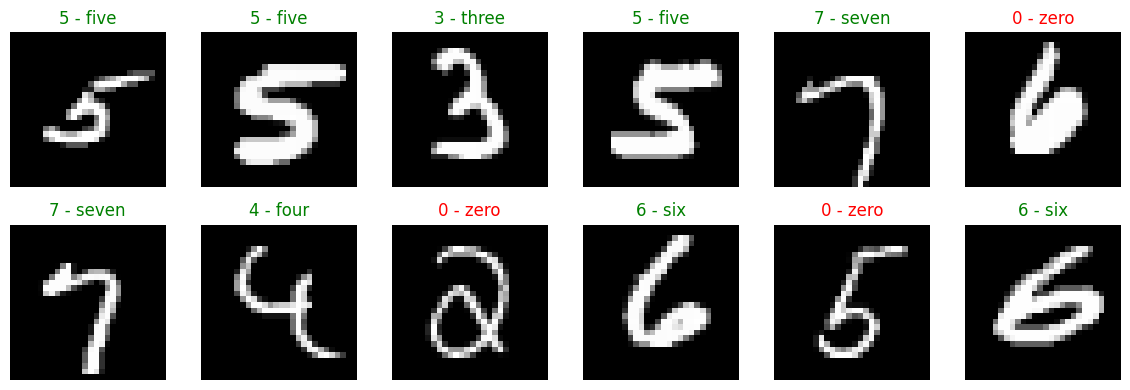

In [ ]:
#  See random images with their labels
torch.manual_seed(42)  # setting random seed
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12, 4))

rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
    img, label_gt = test_dataset[random_idx]
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model_lenet5_v1_mnist_loaded(img_temp))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    plt.imshow(img, cmap='gray')
    if label_pred == label_gt:
        plt.title(class_names[label_pred], color='g') # for correct prediction
    else:
        plt.title(class_names[label_pred], color='r') # for incorrect prediction
    plt.axis(False)
    plt.tight_layout()
